In [1]:
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d.axes3d import Axes3D

%matplotlib inline

In [2]:
class TimeValue:
    def __init__(self, time, value):
        self.time = time * 1.0
        self.value = value * 1.0

    def __repr__(self):
        return '({}, {})'.format(self.time, self.value)

In [3]:
class TimeSeries:
    def __init__(self, points=[]):
        self.series = []
        for (time, value) in points:
            self.append(time, value)
        
    def append(self, time, value):
        self.series.append(TimeValue(time, value))
        self.series = sorted(self.series, key=lambda x: x.time)
        
    @property
    def initial(self):
        return self.series[0]
    
    @property
    def timeline(self):
        return [x.time for x in self.series]
    
    @property
    def values(self):
        return [x.value for x in self.series]
    
    @property
    def components(self, i=None):
        try:
            return list(zip(*self.values))
        except:
            return [self.values]

    def plot(self, toggle='0', loc=None, pad=False, grid=True, marker=None, labels=None, colors=None, lw=1):
        if len(self.components) > 1:
            plt.plot(self.timeline, self.values, marker=marker)
            if loc:
                plt.legend(['x','y','z'][:len(self.components)], loc=loc, numpoints=1)
        else:
            ts = dict()
            ts['0'] = self
            ts['1'] = self.rate_of_change()
            ts['2'] = self.rate_of_change().rate_of_change()
            
            if colors is None:
                colors = [None, None, None]
            else:
                colors = colors * len(toggle) # just in case...

            if labels is None:
                labels = ['position', 'velocity', 'acceleration']
            else:
                labels += [None] * (len(toggle) - len(labels)) # just in case...

            if len(toggle) > 1:
                plt.figure(figsize=(6 * len(toggle), 4))
                
            for i, tog in enumerate(toggle):
                if len(toggle) > 1:
                    plt.subplot(1, len(toggle), toggle.index(tog) + 1)
                plt.plot(ts[tog].timeline, ts[tog].values, marker=marker, 
                         label=labels[i], color=colors[i], lw=lw)
                plt.xlabel('Time')
                if pad:
                    plt.margins(0.05)
                    dt = 0.03 * (self.timeline[-1] - self.timeline[0])
                    plt.axes().set_xlim([self.timeline[0] - dt, self.timeline[-1] + dt])
                if grid:
                    plt.grid(True)
                    plt.gca().axhline(0, c='k')
                if loc and labels[i]:
                    plt.legend(loc=loc, numpoints=1)
                            
    def plot2d(self, toggle='0', x_index=0, y_index=1, title='', colors='', labels=[],
               grid=True, loc=None, markevery=0, arrows=False):
        
        x = dict()
        y = dict()
        
        r = self
        x['0'] = r.components[x_index]
        y['0'] = r.components[y_index]

        v = r.rate_of_change()
        x['1'] = v.components[x_index]
        y['1'] = v.components[y_index]

        a = v.rate_of_change()
        x['2'] = a.components[x_index]
        y['2'] = a.components[y_index]

        color = dict()
        if colors:
            for i, tog in enumerate(toggle):
                color[tog] = colors[i]
        else:
            color['0'] = 'b'
            color['1'] = 'g'
            color['2'] = 'r'            

        label = dict()
        if labels:
            for i, tog in enumerate(toggle):
                label[tog] = labels[i]
        else:
            label['0'] = 'position'
            label['1'] = 'velocity'
            label['2'] = 'acceleration'
                
        for i, tog in enumerate(toggle):
            plt.plot(x[tog], y[tog], c=color[tog], markevery=[-1], 
                     marker='o', mfc='w', mec=color[tog], mew=1)
            if markevery:
                plt.plot(x[tog], y[tog], lw=0, markevery=markevery, 
                         marker='.', mec=color[tog])
            
        plt.axes().set_aspect('equal')
        plt.margins(0.05)
        if loc:
            plt.legend(numpoints=1, loc=loc, labels=labels)
        plt.title(title)
        
        if grid:
            plt.grid(True)
            plt.axes().axhline(0, c='k')
            plt.axes().axvline(0, c='k')

        if arrows:
            xmin, xmax = plt.xlim()
            ymin, ymax = plt.ylim()
            size = 0.5 * (xmax - xmin) + 0.5 * (ymax - ymin)
            head_size = {
                'head_width': 0.03 * size,
                'head_length': 0.05 * size,
            }
            if '1' in toggle:
                plt.axes().arrow(x['0'][-1], y['0'][-1], x['1'][-1], y['1'][-1], 
                                 fc=color['1'], ec=color['1'], **head_size)
            if '2' in toggle:
                plt.axes().arrow(x['0'][-1], y['0'][-1], x['2'][-1], y['2'][-1], 
                                 fc=color['2'], ec=color['2'], **head_size)
             
    @property
    def intervals(self):
        intervals = []
        for i in range(1, len(self.series)):
            intervals.append((self.series[i - 1], self.series[i]))
        return intervals    
 
    def get_interval(self, time): # closed on left [a, b)
        tmin = min(self.timeline)
        tmax = max(self.timeline)
        if time < tmin:
            return None, self.series[0]
        elif time >= tmax:
            return self.series[-1], None
        else:
            for a, b in self.intervals:
                if a.time <= time and time < b.time:
                    return a, b
    
    def rate_of_change(self):
        ts = TimeSeries()
        for i, (a, b) in enumerate(self.intervals):
            dx = b.value - a.value
            dt = b.time - a.time
            if 1 == 0:
                ts.append(a.time, dx/dt)
            else:
                ts.append(a.time + dt/2, dx/dt)
        return ts
                
    def __call__(self, time):
        a, b = self.get_interval(time)
        # this method will not extrapolate, but we do need to take care of this edge case...
        if b is None and round(a.time - time, 10) == 0:
            return a.value
        else:
            dx = b.value - a.value
            dt = b.time - a.time
            return a.value + dx/dt * (time - a.time)

    def __getitem__(self, index):
        if isinstance(index, int):
            return self.series[index]
        elif isinstance(index, slice):
            return self.series[index]
        else:
            raise TypeError("index must be int or slice")
        
    def __repr__(self):
        import pprint
        return pprint.pformat(self.series)


In [78]:
class Particle():
    def __init__(self, mass=1, t0=0, r0=None, v0=None, p0=None):
        
        # The only purpose of the following is to redefine the defaults
        # I am *not* error-checking the input parameters...

        dim = 1
        if isinstance(r0, np.ndarray):
            dim = max(len(r0), dim)
        if isinstance(v0, np.ndarray):
            dim = max(len(v0), dim)

#         if r0 is None and dim > 1:
#             r0 = np.zeros(dim)
#         elif r0 is None:
#             r0 = 0
            
#         if v0 is None and dim > 1:
#             v0 = np.zeros(dim)
#         elif v0 is None:
#             v0 = 0
                    
        if r0 is None:
            r0 = np.zeros(dim)
            
        if v0 is None:
            v0 = np.zeros(dim)
                    
        self.mass = mass
        self.position = TimeSeries([(t0, r0)])
        if self.mass and p0 is None:
            self.momentum = TimeSeries([(t0, self.mass * v0)])
        else:
            self.momentum = TimeSeries([(t0, p0)])
        self.forces = []

    def addforce(self, force):
        self.forces.append(lambda t, obj=self: force(obj, t))        
        
    def netforce(self, time): # momentum flow or rate of change
        netforce = 0
        for f in self.forces:
            netforce += f(time)
        return netforce

    def velocity(self, time): # position flow or rate of change
        if time > max(self.momentum.timeline):
            time = max(self.momentum.timeline)
        return self.momentum(time) / self.mass

    def increment(self, dt, n=1):
        for i in range(n):
            t = max(self.position.timeline)

            if len(self.position.timeline) == 1: # then only go forward half an increment            
                next_p = self.momentum(t) + self.netforce(t) * dt/2
                self.momentum = TimeSeries() # throw out that "initial" value
            else: # reach back half an increment to calculate the new momentum value
                next_p = self.momentum(t - dt/2) + self.netforce(t) * dt

            self.momentum.append(t + dt/2, next_p)
            next_r = self.position(t) + self.velocity(t + dt/2) * dt        
            self.position.append(t + dt, next_r)

In [79]:
class PhysicalSystem():
    def __init__(self, initial=[]):
        self.objs = list()
        for (mass, r0, v0) in initial:
            self.objs.append(Particle(mass=mass, r0=r0, v0=v0))
                    
        for obj1 in self.objs:
            for obj2 in self.objs:
                if obj1 != obj2: # no self-interactions !
                    internal_force = lambda t, obj1=obj1, obj2=obj2: self.interaction(obj1, obj2, t)
                    obj1.forces.append(internal_force)
                    
    def interaction(self, obj1, obj2, time):
        return 0
                    
    def increment(self, dt, n=1):
        for i in range(n):
            for obj in self.objs:
                obj.increment(dt)
                
    def plot(self):
        for i, obj in enumerate(self.objs):
            obj.position.plot(legend_loc=None)
            
    def plot2d(self, colors='bgrcmyk'*9, **kwargs):
        for i, obj in enumerate(self.objs):
            obj.position.plot2d(color=colors[i], **kwargs)

In [59]:
import cmath

class RigidObject(Particle):
    def __init__(self, mass=1, t0=0, r0=0, p0=0, v0=None, moi=1, q0=1+0j, L0=0+0j, w0=None):
        Particle.__init__(self, mass, t0, r0, p0, v0)
        self.moi = moi
        self.attitude = TimeSeries([(t0, q0)])
        self.angular_displacement = TimeSeries([(t0, cmath.phase(q0))])
        if self.moi and w0 is not None:
            self.angular_momentum = TimeSeries([(t0, self.moi * w0)])
        else:
            self.angular_momentum = TimeSeries([(t0, L0)])
        self.torques = []
    
    def add_torque(self, torque):
        self.torques.append(lambda t, obj=self: torque(obj, t))        
        
    def net_torque(self, time): # angular_momentum flow or rate of change
        net_torque = 0+0j
        for tau in self.torques:
            net_torque += tau(time)
        return net_torque

    def rotational_velocity(self, time): # attitude flow or rate of change
        if time > max(self.angular_momentum.timeline):
            time = max(self.angular_momentum.timeline)
        return self.angular_momentum(time) / self.moi
    
    def increment(self, dt, n=1):
        for i in range(n):
            Particle.increment(self, dt, 1)
            
            t = max(self.attitude.timeline)

            if len(self.attitude.timeline) == 1: # then only go forward half an increment            
                next_L = self.angular_momentum(t) + self.net_torque(t) * dt/2
                self.angular_momentum = TimeSeries() # throw out that "initial" value
            else: # reach back half an increment to calculate the new momentum value
                next_L = self.angular_momentum(t - dt/2) + self.net_torque(t) * dt                

                q = self.angular_displacement(t - dt)
                q += self.rotational_velocity(t + dt/2) * dt
                self.angular_displacement.append(t, q)

            self.angular_momentum.append(t + dt/2, next_L)
            rotor = np.exp( 1j * self.rotational_velocity(t + dt/2) * dt )
            next_attitude = self.attitude(t) * rotor
            self.attitude.append(t + dt, next_attitude)

- Ch 01: 1,3,5,12,13,45,46,49,59,61
- Ch 02: 1,3,15,28,29,45,51,53,67,68,78,79,81
- Ch 03: 5,7,8,9,19,30,35,57,59,69,71
- Ch 04: 1,11,38,39,42,56,79,81,98,103,104
- Ch 05: 5,7,8,9,15,23,27,31,41,52,56
- Ch 06: 3,5,6,8,13,19,29,33,38,41,64,68,77
- Ch 07: 1,5,7,19,21,29,31,33,35,41
- Ch 08: 1,3,9,21,23,25,37,39,42,53,54,56,68,69
- Ch 09: 1,6,12,15,31,33,34,48,51,63,64,71,73

## Chapter 3

In [47]:
def weight(obj, t):
    return np.array([0,-9.8])

**Problem 005**

In diving to a depth of 750 meters, an elephant seal also moves 460 meters due east of his starting point. What is the magnitude of the player's displacement.

*Answer:* TBD

In [7]:
x0 = np.array([0,-750])
xf = np.array([460,0])
dx = xf - x0
mag_dx = np.sqrt(dx[0] ** 2 + dx[1] ** 2)
print('Magnitude of displacement = {:.0f} meters'.format(mag_dx))

Magnitude of displacement = 880 meters


**Problem 007**

A radar antenna is tracking a satellite orbiting the earth. At a certain time, the radar screen shows the satellite to be 162 kilometers away. The radar antenna is pointing upward at an angle of 62.3° from the ground. Find the `x` and `y` components (in kilometers) of the position vector of the satellite, relative to the antenna.

*Answer:* TBD

In [8]:
r_mag = 162
q_deg = 62.3
rx = r_mag * np.cos(q_deg * np.pi/180)
ry = r_mag * np.sin(q_deg * np.pi/180)
print('x-component = {:.0f} kilometers'.format(rx))
print('y-component = {:.0f} kilometers'.format(ry))

x-component = 75 kilometers
y-component = 143 kilometers


**Problem 008**

In a mall, a shopper rides up an escalator between floors. At the top of the escalator, the shopper turns right and walks 9.00 meters to a store. The magnitude of the shopper's displacement from the bottom of the escalator to the store is 16.0 meters. The vertical distance between the floors is 6.00 meters. At what angle is the escalator inclined above the horizontal?

*Answer:* TBD

In [46]:
rx = 9.00 # right
ry = None # forward
rz = 6.00 # up

ry = 0
for dy in [1, 0.1, 0.01, 0.001]:
    while True:
        r_mag = np.sqrt( rx ** 2 + ry ** 2 + rz ** 2 )
        if r_mag > 16:
            ry = ry - dy
            break
        else:
            ry = ry + dy

print('Components of the displacement are {:.2f}, {:.2f}, {:.2f}'.format(rx, ry, rz))

angle = np.arctan(ry/rz) * 180/np.pi
print('The angle of the escalator is {:.1f} degrees'.format(angle))

Components of the displacement are 9.00, 11.79, 6.00
The angle of the escalator is 63.0 degrees


**Problem 009**

A skateboarder, starting from rest, rolls down a 12.0-meter ramp. When she arrives at the bottom of the ramp her speed is 7.70 m/s. (a) Determine the magnitude of her acceleration, assumed to be constant. (b) If the ramp is inclined at 25.0° with respect to the ground, what is the component of her acceleration that is parallel to the ground?
          
*Answer:* (a) 2.47 m/s²; (b) 2.24 m/s²

Final position = 12.03 meters (sb 12)
Final speed = 7.700 m/s (sb 7.7)
Acceleration = 2.47 m/s²
Acceleration parallel to the ground = 2.42 m/s²


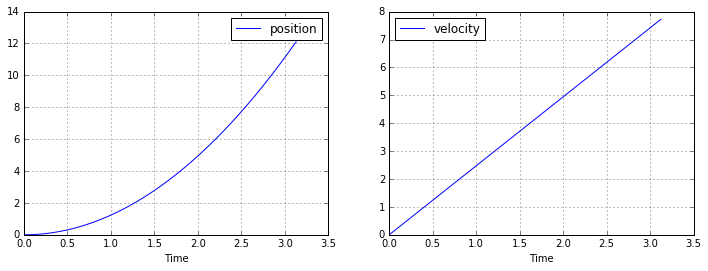

In [77]:
dt = 0.01 # this solution method is very sensitive to `dt` for some reason

a = 0
for da in [1, 0.1, 0.01, 0.001]:
    while True:
        a += da

        obj = Particle(v0=0)
        obj.netforce = lambda t: a
        
        while True:
            t = obj.position.timeline[-1]
            x = obj.position.values[-1]
            v = obj.velocity(t)
            obj.increment(dt)
            if x >= 12 or v >= 7.7:
                break

        if v >= 7.7:
            a += -da
            break

print('Final position = {:.2f} meters (sb 12)'.format(x))
print('Final speed = {:.3f} m/s (sb 7.7)'.format(v))
print('Acceleration = {:.2f} m/s²'.format(a))

ax = a * np.cos(12 * np.pi / 180)
print('Acceleration parallel to the ground = {:.2f} m/s²'.format(ax))

obj.position.plot('01', loc='best', labels=['position','velocity'])
plt.show()

*Alternate solution (2D)*

Final position = 12.03 meters (sb 12)
Final speed = 7.700 m/s (sb 7.7)
Acceleration = 2.47 m/s²
Acceleration parallel to the ground = 2.24 m/s²


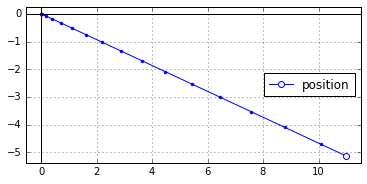

In [76]:
dt = 0.01 # this solution method is very sensitive to `dt` for some reason
q = -25

ax, ay = 0, 0
for da in [1, 0.1, 0.01, 0.001]:
    while True:
        a = np.sqrt(ax ** 2 + ay ** 2)
        a += da
        ax = a * np.cos(q * np.pi/180)
        ay = a * np.sin(q * np.pi/180)
        
        obj = Particle(v0=np.array([0,0]))
        obj.netforce = lambda t: np.array([ax, ay])
        
        while True:
            t = obj.position.timeline[-1]
            r = obj.position.values[-1]
            v = obj.velocity(t)
            r_mag = np.sqrt(r[0] ** 2 + r[1] ** 2)
            v_mag = np.sqrt(v[0] ** 2 + v[1] ** 2)
            obj.increment(dt)

            if r_mag >= 12 or v_mag >= 7.7:
                break

        if v_mag >= 7.7:
            a += -da
            ax = a * np.cos(q * np.pi/180)
            ay = a * np.sin(q * np.pi/180)
            break

print('Final position = {:.2f} meters (sb 12)'.format(r_mag))
print('Final speed = {:.3f} m/s (sb 7.7)'.format(v_mag))
print('Acceleration = {:.2f} m/s²'.format(a))
print('Acceleration parallel to the ground = {:.2f} m/s²'.format(ax))

obj.position.plot2d('0', loc='best', labels=['position'], markevery=20)
plt.show()

**Problem 019**

A golfer imparts a speed of 30.3 m/s to a ball, and it travels the maximum possible distance before landing on the green. The tee and the green are at the same elevation. (a) How much time does the ball spend in the air? (b) What is the longest hole in one that the golfer can make, if the ball does not roll when it hits the green?

*Answer:* (a) 4.37 seconds; (b) 93.7 meters

Final y-displacement = -0.1 (sb 0)
Time in the air = 4.37
Final x-displacement = 93.7


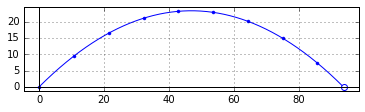

In [74]:
dt = 0.005 # since we want 2 digit accuracy on time, dt must be smaller than 0.01

v0, q = 30.3, 45 # maximum distance implies 45 ... but we could search for this too
vx = v0 * np.cos(q * np.pi/180)
vy = v0 * np.sin(q * np.pi/180)

obj = Particle(v0=np.array([vx,vy]))
obj.addforce(weight)

while True:
    obj.increment(dt)
    if obj.position.values[-1][1] < 0:
        break
        
tf = obj.position.timeline[-1]
xf, yf = obj.position.values[-1]
print('Final y-displacement = {:.1f} (sb 0)'.format(yf))
print('Time in the air = {:.2f}'.format(tf))
print('Final x-displacement = {:.1f}'.format(xf))
obj.position.plot2d(markevery=100)

**Problem 030**

A quarterback claims that he can throw the football a horizontal distance of 183 meters (200 yards). Furthermore, he claims that he can do this by launching the ball at the relatively low angle of 30.0° above the horizontal. To evaluate this claim, determine the speed with which this quarterback must throw the ball. Assume that the ball is launched and caught at the same vertical level and that air resistance can be ignored. For comparison, a baseball pitcher who can accurately throw a fastball at 45 m/s (100 mph) would be considered exceptional.

*Answer:* 47.5 m/s

Final y-position = -0.26 meters (sb 0)
Final x-position = 200.00 meters (sb 200)
Initial speed = 47.52 m/s


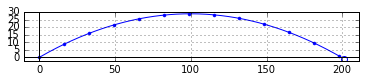

In [126]:
dt = 0.02

v0, q = 0, 30
vx = v0 * np.cos(q * np.pi/180)
vy = v0 * np.sin(q * np.pi/180)

for dv in [1, 0.1, 0.01, 0.001]:
    while True:
        v0 = np.sqrt(vx ** 2 + vy ** 2)
        v0 += dv
        vx = v0 * np.cos(q * np.pi/180)
        vy = v0 * np.sin(q * np.pi/180)
        
        obj = Particle(v0=np.array([vx,vy]))
        obj.addforce(weight)
        
        while True:
            t = obj.position.timeline[-1]
            r = obj.position.values[-1]
            v = obj.velocity(t)
            obj.increment(dt)

            if r[0] > 200 or r[1] < 0:
                break

        if r[0] > 200:
            v0 += -dv
            vx = v0 * np.cos(q * np.pi/180)
            vy = v0 * np.sin(q * np.pi/180)
            break

print('Final y-position = {:.2f} meters (sb 0)'.format(r[1]))
print('Final x-position = {:.2f} meters (sb 200)'.format(r[0]))
print('Initial speed = {:.2f} m/s'.format(v0))

obj.position.plot2d(markevery=20)
plt.show()

**Problem 035**

A rocket is fired at a speed of 75.0 m/s from ground level, at an angle of 60.0° above the horizontal. The rocket is fired toward an 11.0-meter wall, which is located 27.0 meters away. The rocket attains its launch speed in a negligibly short period of time, after which its engines shut down and the rocket coasts. By how much does the rocket clear the top of the wall?

*Answer:* 33.2 meters

Height of rocket is 44.2 meters, which is 33.2 meters above the wall


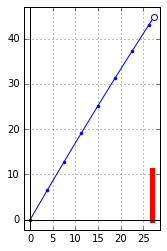

In [140]:
dt = 0.01

v0, q = 75, 60
vx = v0 * np.cos(q * np.pi/180)
vy = v0 * np.sin(q * np.pi/180)

obj = Particle(v0=np.array([vx,vy]))
obj.addforce(weight)

while True:
    t = obj.position.timeline[-1]
    r = obj.position.values[-1]
    v = obj.velocity(t)
    obj.increment(dt)

    if r[0] > 27:
        break
        
print('Height of rocket is {:.1f} meters, which is {:.1f} meters above the wall'.format(r[1], r[1]-11))

# while True:
#     t = obj.position.timeline[-1]
#     r = obj.position.values[-1]
#     v = obj.velocity(t)
#     obj.increment(dt)

#     if r[1] < 0:
#         break

plt.plot([27,27],[0,11],'r',lw=5)
obj.position.plot2d(markevery=10)

**Problme 057**

You are in a hot-air balloon that, relative to the ground, has a velocity of 6.0 m/s in a direction due east. You see a hawk moving directly away from the balloon in a direction due north. The speed of the hawk relative to you is 2.0 m/s. What are the magnitude and direction of the hawk's velocity relative to the ground? Express the directional angle relative to due east.

*Answer:* TBD

In [146]:
balloon_relative_to_ground = np.array([6,0])
hawk_relative_to_balloon = np.array([0,2])

hawk_relative_to_ground = hawk_relative_to_balloon + balloon_relative_to_ground

v = hawk_relative_to_ground
v_mag = np.sqrt( v[0] ** 2 + v[1] ** 2 )
v_ang = np.arctan2(v[1],v[0]) * 180/np.pi

print("Magnitude of hawk's velocity relative to ground is {:.2f} m/s".format(v_mag))
print("Angle of hawk's velocity relative to east is {:.0f}°".format(v_ang))

Magnitude of hawk's velocity relative to ground is 6.32 m/s
Angle of hawk's velocity relative to east is 18°


**Problem 059**

Two passenger trains are passing each other on adjacent tracks. Train A is moving east with a speed of 13 m/s, and train B is traveling wast with a speed of 28 m/s. (a) What is the velocity (magnitude and direction) of train A as seen by the passenders in train B? (b) What is the velocity (magnitude and direction) of train B as seen by the passengers in train A?

*Answer:* TBD

In [147]:
train_A_relative_to_ground = 13
train_B_relative_to_ground = -28

ground_relative_to_train_B = -train_B_relative_to_ground

train_A_relative_to_train_B = train_A_relative_to_ground + ground_relative_to_train_B
print('Velocity of Train A relative to Train B is {:.0f}'.format(train_A_relative_to_train_B))

ground_relative_to_train_A = -train_A_relative_to_ground

train_B_relative_to_train_A = train_B_relative_to_ground + ground_relative_to_train_A
print('Velocity of Train B relative to Train A is {:.0f}'.format(train_B_relative_to_train_A))

Velocity of Train A relative to Train B is 41
Velocity of Train B relative to Train A is -41


**Problem 069**

A golf ball rolls off a horizontal cliff with an initial speed of 11.4 m/s. The ball falls a vertical distance of 15.5 meters into a lake below. (a) How much time does the ball spend in the air? (b) What is the speed `v` of the ball just before it strikes the water?

*Answer:* TBD

Final height = -0.0 meters
Time of flight = 1.8 seconds
Final speed = 20.8 m/s


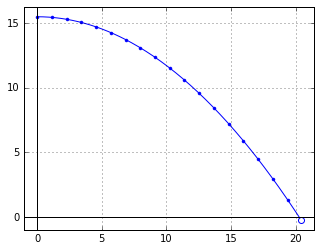

In [151]:
dt = 0.01

v0, q = 11.4, 0
vx = v0 * np.cos(q * np.pi/180)
vy = v0 * np.sin(q * np.pi/180)

rx = 0
ry = 15.5

obj = Particle(r0=np.array([rx,ry]),v0=np.array([vx,vy]))
obj.addforce(weight)

while True:
    t = obj.position.timeline[-1]
    r = obj.position.values[-1]
    v = obj.velocity(t)
    obj.increment(dt)

    if r[1] < 0:
        break
        
tf = obj.position.timeline[-1]
vf = np.sqrt( v[0] ** 2 + v[1] ** 2 )

print('Final height = {:.1f} meters'.format(r[1]))
print('Time of flight = {:.1f} seconds'.format(tf))
print('Final speed = {:.1f} m/s'.format(vf))

obj.position.plot2d(markevery=10)

**Problem 071**

A diver runs horizontally with a speed of 1.20 m/s off a platform that is 10.0 meters above the water. What is his speed just before striking the water?

*Answer:* TBD

Final height = -0.0 meters
Time of flight = 1.4 seconds
Final speed = 14.0 m/s


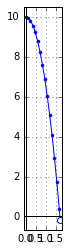

In [152]:
dt = 0.01

v0, q = 1.2, 0
vx = v0 * np.cos(q * np.pi/180)
vy = v0 * np.sin(q * np.pi/180)

rx = 0
ry = 10.0

obj = Particle(r0=np.array([rx,ry]),v0=np.array([vx,vy]))
obj.addforce(weight)

while True:
    t = obj.position.timeline[-1]
    r = obj.position.values[-1]
    v = obj.velocity(t)
    obj.increment(dt)

    if r[1] < 0:
        break
        
tf = obj.position.timeline[-1]
vf = np.sqrt( v[0] ** 2 + v[1] ** 2 )

print('Final height = {:.1f} meters'.format(r[1]))
print('Time of flight = {:.1f} seconds'.format(tf))
print('Final speed = {:.1f} m/s'.format(vf))

obj.position.plot2d(markevery=10)